##Model Training

**Mounting Google Drive in Google Colab**

Google Drive to the Colab environment, enabling access to files stored in Drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Setting Up Apache Spark in Google Colab**

This code installs OpenJDK 8, sets up Apache Spark by extracting it from the specified Google Drive location, and installs the necessary Python libraries (findspark and pyspark) for Spark integration. It also sets environment variables for Java and Spark paths to enable Spark execution in the Colab environment.

In [2]:
!ls /content/drive/MyDrive/DESProject/SparkData/spark-3.5.3-bin-hadoop3.tgz
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!tar xf /content/drive/MyDrive/DESProject/SparkData/spark-3.5.3-bin-hadoop3.tgz
!pip install -q findspark
!pip install -q pyspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.3-bin-hadoop3"

/content/drive/MyDrive/DESProject/SparkData/spark-3.5.3-bin-hadoop3.tgz


**Linking Google Drive Files to a Local Directory**

In [3]:
!mkdir /content/data
!ln -s /content/drive/MyDrive/DESProject/* /content/data/

**Initializing PySpark in Google Colab**

This code initializes the findspark library, starts a Spark session with a specified configuration, and sets up PySpark to run locally in Google Colab.

In [4]:
#######################################
###!@ START OF PYSPARK INIT
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
input_type = 'sample'
spark = SparkSession.builder\
         .master("local")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()
# Spark is ready to go within Colab!
###!@ END OF PYSPARK INIT

**Loading CSV Data into Spark DataFrame**

This reads a CSV file from the specified path into a Spark DataFrame, inferring the schema and using the first row as column headers.

In [59]:
df = spark.read.csv("/content/data/Phishing_URL_Dataset.csv", header=True, inferSchema=True)

**Base Imports for PySpark ML Pipeline**

In [60]:
#######################################
###!@START BASE IMPORTS
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import Evaluator
from pyspark.sql.types import *
from pyspark.sql.functions import col, abs
import pyspark.sql.functions as F
from pyspark.sql.window import Window as W
from pyspark.ml.feature import *
from pyspark.ml.linalg import Vectors, VectorUDT
import time

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, NaiveBayes, LinearSVC
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import RandomForestClassificationModel

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

###!@END BASE IMPORTS

**Selected Features for Phishing URL Classification**

This list includes the top 10 features selected based on extensive experimentation and performance evaluation, showing high accuracy and optimal results in the phishing URL classification model.

In [61]:
selected_features = [
    "URLSimilarityIndex",
"LineOfCode",
"NoOfExternalRef",
"NoOfSelfRef",
"NoOfCSS",
"NoOfImage",
"HasSocialNet",
"HasCopyrightInfo",
"HasDescription",
"NoOfJS"
]

**Defining Feature and Target Columns for Model Training**

This code selects the previously identified features for model training and defines the target column (label) to be predicted, preparing the dataset for further processing and model building.

In [62]:
# Select only selected features
feature_columns = selected_features

# Define target column
target_column = 'label'

print("Features:", feature_columns)
print("Target:", target_column)

Features: ['URLSimilarityIndex', 'LineOfCode', 'NoOfExternalRef', 'NoOfSelfRef', 'NoOfCSS', 'NoOfImage', 'HasSocialNet', 'HasCopyrightInfo', 'HasDescription', 'NoOfJS']
Target: label


**Assembling Features and Transforming Dataset**

This uses VectorAssembler to combine the selected feature columns into a single 'features' column, then transforms the dataset to include this new column alongside the target column (label).

In [63]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Transform the dataset
df = assembler.transform(df)

# View the dataset with features and target
df.select('features', target_column).show(5)


+--------------------+-----+
|            features|label|
+--------------------+-----+
|[100.0,558.0,124....|    1|
|[100.0,618.0,217....|    1|
|[100.0,467.0,5.0,...|    1|
|[100.0,6356.0,31....|    1|
|[100.0,6089.0,85....|    1|
+--------------------+-----+
only showing top 5 rows



**Splitting the Data into Training and Testing Sets**

This splits the dataset into 80% training data and 20% testing data using a random split, then prints the number of records in each subset to ensure proper data distribution

In [64]:
# Splitting the data into 80% training and 20% testing
train_data, test_data = df.randomSplit([0.8, 0.2], seed=1947)

# Print the number of records in each set
print(f"Training Data Count: {train_data.count()}")
print(f"Testing Data Count: {test_data.count()}")


Training Data Count: 188572
Testing Data Count: 47223


**Label Distribution in Training and Testing Sets**

This code groups the training and testing datasets by the label column and counts the number of instances in each label category, displaying the distribution of labels in both sets to check for balance or imbalance.

In [65]:
# distribution of the label in the training set
train_data.groupBy("label").count().show()

# distribution of the label in the testing set
test_data.groupBy("label").count().show()


+-----+------+
|label| count|
+-----+------+
|    1|107714|
|    0| 80858|
+-----+------+

+-----+-----+
|label|count|
+-----+-----+
|    1|27136|
|    0|20087|
+-----+-----+



**We will evaluate four classification models: Random Forest, Decision Tree, SVM, and Naive Bayes. Each model will be tuned using hyperparameters and cross-validation to optimize performance. The models will be compared using performance metrics such as accuracy, precision, recall, and F1 score. Based on these metrics, the best-performing model will be identified.**

**Defining Evaluation Metric for Classification Model**

Defines a MulticlassClassificationEvaluator to evaluate the accuracy of the model by comparing the predicted labels (prediction) with the actual labels (label) in the dataset.

In [66]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")


**Defining Random Forest Classifier Model**

This defines a RandomForestClassifier in PySpark, specifying the columns for the label (label) and the features (features) to be used in training the model.

In [67]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

**Defining Hyperparameter Grid for Random Forest**

This creates a parameter grid using ParamGridBuilder to tune the Random Forest classifier's hyperparameters, specifically numTrees (number of trees) and maxDepth (maximum depth of the trees), with specified values for each.

In [68]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()


**Setting Up Cross-Validation for Random Forest**

Below code sets up a CrossValidator to perform hyperparameter tuning for the Random Forest classifier. It uses the defined parameter grid (paramGrid), evaluator (evaluator), and 3-fold cross-validation to select the best model.

In [69]:
rf_cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

**Training, Testing, and Evaluating the Random Forest Model**

This code trains a Random Forest model using cross-validation, tests it on the test data, evaluates the accuracy, and prints the best hyperparameters. It also tracks the duration of the training and testing process, displaying the time taken in seconds along with the results.

In [70]:
# Record start time for training
train_start_time = time.time()

# Train model
rf_cv_model = rf_cv.fit(train_data)

# Record end time for training
train_end_time = time.time()
train_duration = train_end_time - train_start_time
print(f"Training Duration: {train_duration:.2f} seconds")
# Record start time for testing
test_start_time = time.time()

# Test model
rf_predictions = rf_cv_model.bestModel.transform(test_data)
rf_accuracy = evaluator.evaluate(rf_predictions)

# Record end time for testing
test_end_time = time.time()
test_duration = test_end_time - test_start_time
print(f"Testing Duration: {test_duration:.2f} seconds")
# Output results
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"Best Hyperparameters: ")
best_params = rf_cv_model.bestModel.extractParamMap()
for param, value in best_params.items():
    print(f"{param.name}: {value}")


Training Duration: 380.07 seconds
Testing Duration: 7.02 seconds
Random Forest Accuracy: 1.0000
Best Hyperparameters: 
bootstrap: True
cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: auto
featuresCol: features
impurity: gini
labelCol: label
leafCol: 
maxBins: 32
maxDepth: 10
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
minWeightFractionPerNode: 0.0
numTrees: 50
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: 7698096425215377372
subsamplingRate: 1.0


**Defining Decision Tree Model**

 This defines a Decision Tree model in PySpark using the DecisionTreeClassifier class, with the target variable (label) and feature vector (features) specified for classification tasks.

In [71]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

**Defining Hyperparameter Grid for Decision Tree Model**

This creates a parameter grid for hyperparameter tuning of the Decision Tree model, testing different values for maxDepth and minInstancesPerNode using ParamGridBuilder. This helps optimize the model during cross-validation


In [72]:
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10]) \
    .addGrid(dt.minInstancesPerNode, [1, 5]) \
    .build()

**Setting Up Cross-Validation for Decision Tree Model**

This sets up a CrossValidator for the Decision Tree model, specifying the parameter grid, evaluator (for accuracy), and number of folds (3) for cross-validation. This allows for hyperparameter optimization and model evaluation.

In [73]:
dt_cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

**Decision Tree Model Trainin , Testing & Evaluating**

 This code tracks the training and testing durations for a Decision Tree model. It first measures the time taken to train the model using cross-validation, then tests the model and evaluates its accuracy. It also outputs the best hyperparameters identified during training.

In [74]:
# Start time for training
start_train_time = time.time()

# Train model
dt_cv_model = dt_cv.fit(train_data)

# End time for training
end_train_time = time.time()
train_duration = end_train_time - start_train_time
print(f"Training Duration: {train_duration:.2f} seconds")
# Start time for testing
start_test_time = time.time()

# Test model
dt_predictions = dt_cv_model.bestModel.transform(test_data)
dt_accuracy = evaluator.evaluate(dt_predictions)

# End time for testing
end_test_time = time.time()
test_duration = end_test_time - start_test_time
print(f"Testing Duration: {test_duration:.2f} seconds")
# Output result
print(f"Decision Tree Accuracy: {dt_accuracy:.4f}")
print(f"Best Decision Tree Hyperparameters: ")
best_params = dt_cv_model.bestModel.extractParamMap()
for param, value in best_params.items():
    print(f"{param.name}: {value}")


Training Duration: 102.40 seconds
Testing Duration: 6.13 seconds
Decision Tree Accuracy: 1.0000
Best Decision Tree Hyperparameters: 
cacheNodeIds: False
checkpointInterval: 10
featuresCol: features
impurity: gini
labelCol: label
leafCol: 
maxBins: 32
maxDepth: 5
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
minWeightFractionPerNode: 0.0
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: 2631112019678092941


**Naive Bayes Model Definition**

This defines a Naive Bayes model for classification, specifying the target label column as "label" and the feature column as "features" for training and prediction in a PySpark environment.

In [75]:
nb = NaiveBayes(labelCol="label", featuresCol="features")

**Defining Hyperparameter Grid for Naive Bayes Model**

This defines a parameter grid for tuning the Naive Bayes model, specifically focusing on the smoothing parameter, with values 0.5, 1.0, and 2.0, using PySpark's ParamGridBuilder for hyperparameter tuning.

In [76]:
paramGrid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.5, 1.0, 2.0]) \
    .build()

**Setting Up Cross-Validation for Naive Bayes Model**

This code sets up a cross-validation process for the Naive Bayes model using PySpark's CrossValidator. The parameter grid is passed to tune hyperparameters, and the evaluation is done using 3-fold cross-validation.

In [77]:
nb_cv = CrossValidator(estimator=nb, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

**Training, Testing, and Evaluating the Naive Bayes Model**

This code trains a Naive Bayes model using cross-validation, tests it on the test data, evaluates the accuracy, and prints the best hyperparameters. It also tracks the duration of the training and testing process, displaying the time taken in seconds along with the results.

In [78]:
# Start time for training
start_train_time = time.time()

# Train model
nb_cv_model = nb_cv.fit(train_data)

# End time for training
end_train_time = time.time()
train_duration = end_train_time - start_train_time
print(f"Training Duration: {train_duration:.2f} seconds")
# Start time for testing
start_test_time = time.time()

# Test model
nb_predictions = nb_cv_model.bestModel.transform(test_data)
nb_accuracy = evaluator.evaluate(nb_predictions)

# End time for testing
end_test_time = time.time()
test_duration = end_test_time - start_test_time
print(f"Testing Duration: {test_duration:.2f} seconds")
# Output results
print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")

# Output the best hyperparameters for Naive Bayes
print(f"Best Naive Bayes Hyperparameters: ")
best_params = nb_cv_model.bestModel.extractParamMap()
for param, value in best_params.items():
    print(f"{param.name}: {value}")


Training Duration: 50.12 seconds
Testing Duration: 3.36 seconds
Naive Bayes Accuracy: 0.9050
Best Naive Bayes Hyperparameters: 
featuresCol: features
labelCol: label
modelType: multinomial
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
smoothing: 0.5


**Defining SVM Model**

 This defines the Support Vector Machine (SVM) model using PySpark's LinearSVC. The model is configured with labelCol and featuresCol parameters, indicating the target and input feature columns.

In [79]:
svm = LinearSVC(labelCol="label", featuresCol="features")

**Defining Hyperparameter Grid for SVM Model**

 This code defines the parameter grid for the SVM model, specifying two hyperparameters: maxIter (maximum number of iterations) and regParam (regularization parameter), with different values to be tested during cross-validation.

In [80]:
paramGrid = ParamGridBuilder() \
    .addGrid(svm.maxIter, [50, 100]) \
    .addGrid(svm.regParam, [0.01, 0.1]) \
    .build()

**Setting Up Cross-Validation for SVM Model**

This code configures a CrossValidator for the SVM model, defining the parameter grid and using 3-fold cross-validation to tune hyperparameters

In [81]:
svm_cv = CrossValidator(estimator=svm, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)


**Training, Testing, and Evaluating the SVM Model**

This trains a SVM model using cross-validation, tests it on the test data, evaluates the accuracy, and prints the best hyperparameters. It also tracks the duration of the training and testing process, displaying the time taken in seconds along with the results.

In [82]:
# Start time for training
start_train_time = time.time()

# Train model
svm_cv_model = svm_cv.fit(train_data)

# End time for training
end_train_time = time.time()
train_duration = end_train_time - start_train_time
print(f"Training Duration: {train_duration:.2f} seconds")
# Start time for testing
start_test_time = time.time()

# Test model
svm_predictions = svm_cv_model.bestModel.transform(test_data)
svm_accuracy = evaluator.evaluate(svm_predictions)

# End time for testing
end_test_time = time.time()
test_duration = end_test_time - start_test_time
print(f"Testing Duration: {test_duration:.2f} seconds")
# Output results
print(f"SVM Accuracy: {svm_accuracy:.4f}")

# Output the best hyperparameters for SVM
print(f"Best SVM Hyperparameters: ")
best_params = svm_cv_model.bestModel.extractParamMap()
for param, value in best_params.items():
    print(f"{param.name}: {value}")


Training Duration: 163.53 seconds
Testing Duration: 8.13 seconds
SVM Accuracy: 0.9966
Best SVM Hyperparameters: 
aggregationDepth: 2
featuresCol: features
fitIntercept: True
labelCol: label
maxBlockSizeInMB: 0.0
maxIter: 50
predictionCol: prediction
rawPredictionCol: rawPrediction
regParam: 0.01
standardization: True
threshold: 0.0
tol: 1e-06


**Model Comparison and Evaluation: Random Forest, Decision Tree, Naive Bayes, and SVM**

This analysis tests four machine learning models — Random Forest, Decision Tree, Naive Bayes, and SVM — using cross-validation and hyperparameter tuning. The models are evaluated based on accuracy, precision, recall, and F1-score. The best performing model is identified based on these metrics.

In [83]:
# Define a function to evaluate metrics for each model
def evaluate_model(model_name, model, test_data):
    # Generate predictions
    predictions = model.transform(test_data)

    # Initialize evaluators for each metric
    accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
    recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
    f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

    # Calculate metrics
    accuracy = accuracy_evaluator.evaluate(predictions)
    precision = precision_evaluator.evaluate(predictions)
    recall = recall_evaluator.evaluate(predictions)
    f1 = f1_evaluator.evaluate(predictions)

    # Return results as a dictionary
    return {
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
    }

# Evaluate all models
results = []

# Random Forest
results.append(evaluate_model("Random Forest", rf_cv_model.bestModel, test_data))

# Decision Tree
results.append(evaluate_model("Decision Tree", dt_cv_model.bestModel, test_data))

# Naive Bayes
results.append(evaluate_model("Naive Bayes", nb_cv_model.bestModel, test_data))

# SVM
results.append(evaluate_model("SVM", svm_cv_model.bestModel, test_data))

# Display results in a sorted order based on F1-Score
results_sorted = sorted(results, key=lambda x: x["F1-Score"], reverse=True)

# Print results
print("\nComparison of Models:")
for result in results_sorted:
    print(f"Model: {result['Model']}")
    print(f"  Accuracy: {result['Accuracy']:.4f}")
    print(f"  Precision: {result['Precision']:.4f}")
    print(f"  Recall: {result['Recall']:.4f}")
    print(f"  F1-Score: {result['F1-Score']:.4f}")
    print()

# Identify the best model
best_model = results_sorted[0]
print(f"Best Model: {best_model['Model']}")
print(f"  Accuracy: {best_model['Accuracy']:.4f}")
print(f"  Precision: {best_model['Precision']:.4f}")
print(f"  Recall: {best_model['Recall']:.4f}")
print(f"  F1-Score: {best_model['F1-Score']:.4f}")



Comparison of Models:
Model: Random Forest
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000

Model: Decision Tree
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000

Model: SVM
  Accuracy: 0.9966
  Precision: 0.9966
  Recall: 0.9966
  F1-Score: 0.9966

Model: Naive Bayes
  Accuracy: 0.9050
  Precision: 0.9049
  Recall: 0.9050
  F1-Score: 0.9049

Best Model: Random Forest
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000


**Confusion Matrix Comparison for Phishing Detection Models**

This calculates and visualizes the confusion matrices for four classification models (Random Forest, Decision Tree, Naive Bayes, and SVM) to evaluate their performance in distinguishing between phishing (0) and legitimate (1) URLs.

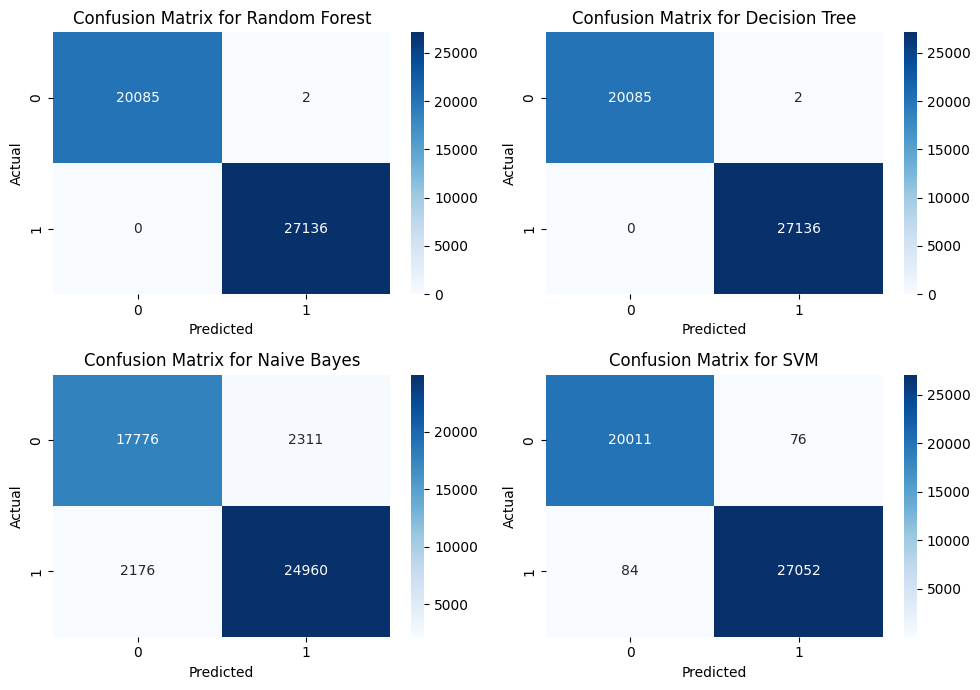

In [84]:
# Function to calculate confusion matrix
def get_confusion_matrix(model, test_data):
    predictions = model.transform(test_data)
    # Ensure the prediction column is in integer format
    confusion_matrix = predictions.groupBy("label", "prediction").count().toPandas()

    # Labels for confusion matrix (0 = Phishing, 1 = Legitimate)
    labels = [0, 1]

    # Initialize the matrix with zeros
    matrix = np.zeros((len(labels), len(labels)), dtype=int)

    # Populate the confusion matrix
    for _, row in confusion_matrix.iterrows():
        actual = int(row["label"])  # Convert label to integer
        predicted = int(row["prediction"])  # Convert prediction to integer
        matrix[actual, predicted] = row["count"]

    return matrix, labels

# Function to plot a confusion matrix heatmap
def plot_confusion_matrix(matrix, labels, model_name, ax):
    sns.heatmap(matrix, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(f"Confusion Matrix for {model_name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

fig, axes = plt.subplots(2, 2, figsize=(10, 7))

# List to store confusion matrices for each model
confusion_matrices = []

# Generate confusion matrices for each model
models = [
    ("Random Forest", rf_cv_model.bestModel),
    ("Decision Tree", dt_cv_model.bestModel),
    ("Naive Bayes", nb_cv_model.bestModel),
    ("SVM", svm_cv_model.bestModel),
]

# Plot confusion matrices for each model
for idx, (model_name, model) in enumerate(models):
    matrix, labels = get_confusion_matrix(model, test_data)
    row = idx // 2  # Determine row (0 or 1)
    col = idx % 2   # Determine column (0 or 1)
    plot_confusion_matrix(matrix, labels, model_name, axes[row, col])

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


**Displaying Feature Importances from Best Model (Random Forest Model)**

This extracts and displays the feature importances from a trained Random Forest model, sorting them in descending order to highlight the most influential features in the prediction.

In [85]:
# Access feature importances from the trained Random Forest model
importances = rf_cv_model.bestModel.featureImportances.toArray()

# Map features to their importance scores
feature_importances = [(feature, importance) for feature, importance in zip(feature_columns, importances)]

# Sort and display feature importances
sorted_features = sorted(feature_importances, key=lambda x: x[1], reverse=True)
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")


URLSimilarityIndex: 0.5120
NoOfExternalRef: 0.1811
NoOfSelfRef: 0.1396
LineOfCode: 0.1091
NoOfImage: 0.0345
NoOfJS: 0.0154
HasSocialNet: 0.0056
HasCopyrightInfo: 0.0014
NoOfCSS: 0.0010
HasDescription: 0.0004


**Saving the Best Random Forest Model in PySpark**

This code saves the best model obtained from cross-validation (Random Forest) to a specified location in the local file system or cloud storage. The model is saved in a format compatible with PySpark, allowing for future use or deployment without the need to retrain.

In [53]:
best_model = rf_cv_model.bestModel

# Save the model to the local file system
best_model.save("/content/drive/MyDrive/DESProject/best_random_forest_model.model")

**To load the saved Random Forest model from PySpark (if required)**


In [ ]:
loaded_model = RandomForestClassificationModel.load("/content/drive/MyDrive/DESProject/best_random_forest_model.model")